<center>
    <img src="https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/Logos/organization_logo/organization_logo.png" width="300" alt="cognitiveclass.ai logo"  />
</center>

<h1 align="center"><font size="5">Classification with Python</font></h1>


In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:


In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset


This dataset is about past loans. The **Loan_train.csv** data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
| -------------- | ------------------------------------------------------------------------------------- |
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |


Lets download the dataset


In [2]:
!wget -O loan_train.csv https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv

--2021-02-18 17:47:43--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 198.23.119.245
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|198.23.119.245|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

loan_train.csv      100%[===================>]  22.56K  --.-KB/s    in 0s      

2021-02-18 17:47:43 (117 MB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File


In [3]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [4]:
df.shape

(346, 10)

### Convert to date time object


In [5]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing


Let’s see how many of each class is in our data set 


In [6]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:


In [7]:
# # notice: installing seaborn might takes a few minutes
# !conda install -c anaconda seaborn -y

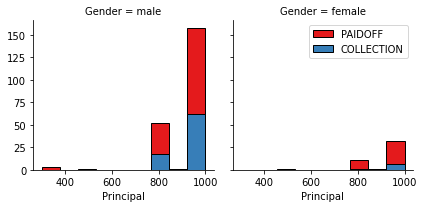

In [8]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

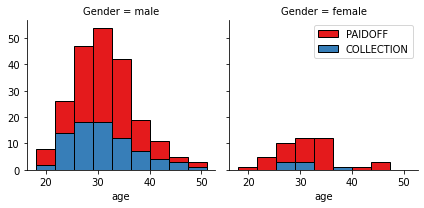

In [9]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction


### Lets look at the day of the week people get the loan


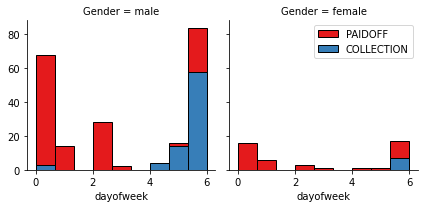

In [10]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 


In [11]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values


Lets look at gender:


In [12]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [13]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding

#### How about education?


In [14]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature befor One Hot Encoding


In [15]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame


In [16]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection


Lets defind feature sets, X:


In [17]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?


In [18]:
#change the values of y to be binary 1 or 2 
df['loan_status'].replace(to_replace =["PAIDOFF","COLLECTION"], value = [1,0], inplace=True)

## Normalize Data


In [19]:
y = df['loan_status']

Data Standardization give data zero mean and unit variance (technically should be done after train test split )


In [20]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification


Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:

-   K Nearest Neighbor(KNN)
-   Decision Tree
-   Support Vector Machine
-   Logistic Regression

** Notice:** 

-   You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
-   You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
-   You should include the code of the algorithm in the following cells.


# K Nearest Neighbor(KNN)

Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the **loan_test.csv** for finding the best k, however, you can split your train_loan.csv into train and test to find the best **k**.


In [21]:
#Create train and test data 
from sklearn.model_selection import train_test_split 
from sklearn.neighbors import KNeighborsClassifier

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.20, random_state = 4)

#print the shape of X and Y train and test datasets
print("Shape of X_train is", X_train.shape, "Shape of y_train is", y_train.shape)
print("Shape of X_test is", X_test.shape, "Shape of y_test is", y_test.shape)

Shape of X_train is (276, 8) Shape of y_train is (276,)
Shape of X_test is (70, 8) Shape of y_test is (70,)


### Step 1 - Finding the best value for K

In [22]:
from sklearn import metrics
f1_scores = np.zeros((20-1))

for k in range(1,20):
    Kneighbors = KNeighborsClassifier(n_neighbors=k)
    Kneighbors.fit(X_train, y_train)
    yhat = Kneighbors.predict(X_test)
    f1_scores[k-1] = metrics.f1_score(y_test, yhat, average="weighted")

print("the best weighted k is ",f1_scores.argmax()+1)

the best weighted k is  7


Text(0, 0.5, 'Jaccard Accuracy Score')

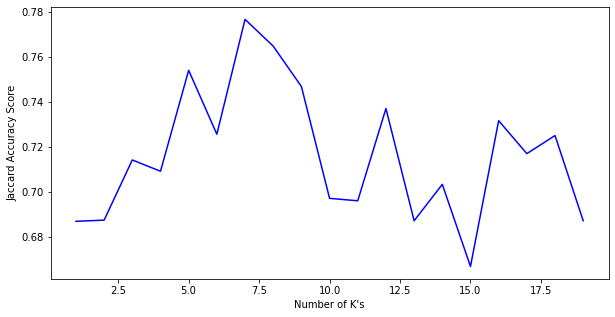

In [23]:
#plot results 
plt.figure(figsize=(10,5))
plt.plot(range(1,20), f1_scores, "b")
plt.xlabel("Number of K's")
plt.ylabel("Jaccard Accuracy Score")

### Step 2 - Building the Model with the best K = 5

In [24]:
#Running Model with best K 
print("Building model with best K = 5")
Kneighbors = KNeighborsClassifier(n_neighbors=5)
Kneighbors.fit(X_train, y_train)
yhat = Kneighbors.predict(X_test)

Building model with best K = 5


### Step 3 - Evaluating the Model using f1 score and jaccard similarity score

In [25]:
from sklearn.metrics import f1_score
print("f1 score for N-Nearst Neighbor Algorithm:", metrics.f1_score(y_test,yhat,average="weighted"))
print("Jaccard Index score for N-Nearst Neighbor Algorithm:", metrics.jaccard_score(y_test,yhat, average="weighted"))

f1 score for N-Nearst Neighbor Algorithm: 0.7540496161185816
Jaccard Index score for N-Nearst Neighbor Algorithm: 0.6329095496894409


### Step 4 - Draw a confusion Matrix to visualize results 

[[47  8]
 [ 9  6]]
Confusion matrix, without normalization
[[47  8]
 [ 9  6]]


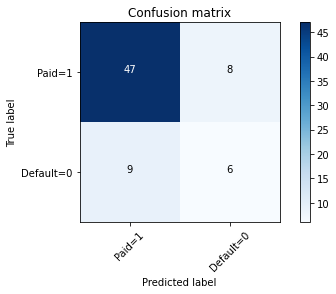

In [26]:
#This function computes the confusion matrix 
from sklearn.metrics import classification_report, confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
print(confusion_matrix(y_test, yhat, labels=[1,0]))


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat, labels=[1,0])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Paid=1','Default=0'],normalize= False,  title='Confusion matrix')

# Decision Tree


### Searching for the Best Node Depth Value

The best depth is: 1
[0.88 0.88 0.73 0.73 0.74 0.87 0.86 0.86 0.77 0.82 0.82 0.81 0.8  0.82
 0.83 0.8  0.8  0.79 0.8  0.8 ]


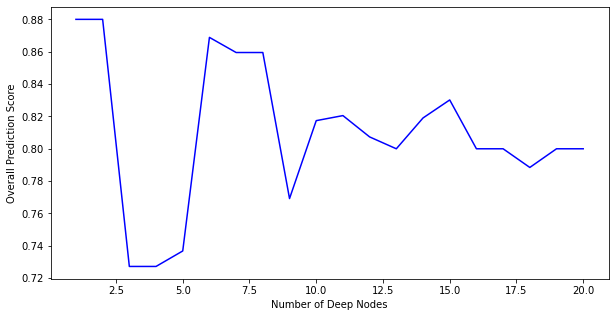

In [27]:
from sklearn.tree import DecisionTreeClassifier
#In search for best node depth
Dt_scores = np.zeros((20))

for k in range(1,21):
  Dt = DecisionTreeClassifier(criterion="entropy", max_depth=k)
  Dt.fit(X_train, y_train)
  yhat = Dt.predict(X_test)
  Dt_scores[k-1] = metrics.f1_score(y_test, yhat) 

print("The best depth is:", Dt_scores.argmax()+1)
#plot results 
plt.figure(figsize=(10,5))
plt.plot(range(1,21), Dt_scores, "b")
plt.xlabel("Number of Deep Nodes")
plt.ylabel("Overall Prediction Score")
print(Dt_scores)

### Building Decision tree with max depth of 2 

In [28]:
from sklearn.tree import DecisionTreeClassifier
Dt = DecisionTreeClassifier(criterion="entropy", max_depth=2)
#fit X train and y train 
Dt.fit(X_train,y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=2)

### Confusion Matrix 

Confusion matrix, without normalization
[[42 13]
 [ 8  7]]


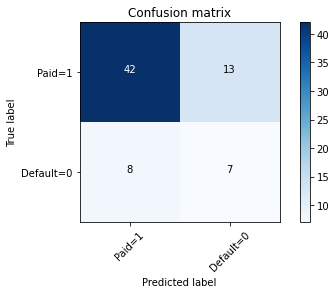

In [29]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat, labels=[1,0])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Paid=1','Default=0'],normalize= False,  title='Confusion matrix')

### Run evaluation using F1 and Jaccard Similarity Index

In [30]:
yhat = Dt.predict(X_test)
print("F1 Score for test set", metrics.f1_score(y_test, yhat, average="weighted"))
print("Jaccard Index score for test set", metrics.jaccard_score(y_test, yhat, average="weighted"))


F1 Score for test set 0.6914285714285714
Jaccard Index score for test set 0.6173469387755102


# Support Vector Machine


### Finding the best Kernel 

In [31]:
from sklearn.svm import SVC
import numpy as np
svm_scores = np.zeros((4))

for k in ("linear", "poly", "rbf", "sigmoid"):
  clf = SVC(kernel = k)
  clf.fit(X_train, y_train)
  yhat = clf.predict(X_test)
  print("kernel:{}, acc score is {}".format(k, metrics.f1_score(y_test,yhat,average="weighted")))

kernel:linear, acc score is 0.6914285714285714
kernel:poly, acc score is 0.7064793130366899
kernel:rbf, acc score is 0.7275882012724117
kernel:sigmoid, acc score is 0.6892857142857144


### Best Kernel is RBF so we will build an algorithm using it 

In [32]:
lin_svm = SVC(kernel="rbf")
lin_svm.fit(X_train, y_train)
yhat = lin_svm.predict(X_test)

### Visualize Results in Confusion Matrix

Confusion matrix, without normalization
[[48  7]
 [11  4]]


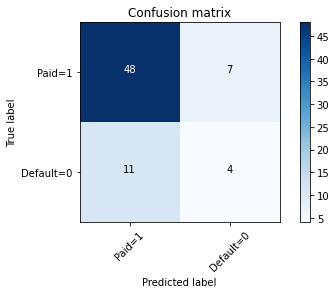

In [33]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat, labels=[1,0])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Paid=1','Default=0'],normalize= False,  title='Confusion matrix')

### Evaluate using F1-Score and Jaccard Similarity Index

In [34]:
print("F1 Score for test set", metrics.f1_score(y_test, yhat, average="weighted"))
print("Jaccard Index score for test set", metrics.jaccard_score(y_test, yhat, average="weighted"))
print(classification_report(y_test, yhat))

F1 Score for test set 0.7275882012724117
Jaccard Index score for test set 0.6103896103896104
              precision    recall  f1-score   support

           0       0.36      0.27      0.31        15
           1       0.81      0.87      0.84        55

    accuracy                           0.74        70
   macro avg       0.59      0.57      0.57        70
weighted avg       0.72      0.74      0.73        70



# Logistic Regression


### Find the best Solver 

In [35]:
from sklearn.linear_model import LogisticRegression


for k in ('lbfgs', 'saga', 'liblinear', 'newton-cg', 'sag'):
  LR = LogisticRegression(C=0.01, solver=k).fit(X_train, y_train)
  yhat = LR.predict(X_test)
  yprob = LR.predict_proba(X_test)
  print(k, "log-loss ---", metrics.log_loss(y_test, yprob))

lbfgs log-loss --- 0.4920179847937498
saga log-loss --- 0.4920183092282414
liblinear log-loss --- 0.5772287609479654
newton-cg log-loss --- 0.4920178014679269
sag log-loss --- 0.49201543244527357


### Build model using best solver which is Liblinear

In [36]:
LR = LogisticRegression(C=0.01, solver="liblinear").fit(X_train, y_train)
yhat = LR.predict(X_test)

### Visualize results in Confusion Matrix 

Confusion matrix, without normalization
[[46  9]
 [13  2]]


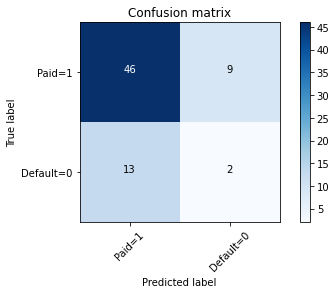

In [37]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat, labels=[1,0])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Paid=1','Default=0'],normalize= False,  title='Confusion matrix')

### Evaluate Model using F1-Score and Jaccard Similarity Index

In [38]:
print("F1 Score for test set", metrics.f1_score(y_test, yhat, average="weighted"))
print("Jaccard Index score for test set", metrics.jaccard_score(y_test, yhat, average="weighted"))
print(classification_report(y_test, yhat))

F1 Score for test set 0.6670522459996144
Jaccard Index score for test set 0.5493697478991597
              precision    recall  f1-score   support

           0       0.18      0.13      0.15        15
           1       0.78      0.84      0.81        55

    accuracy                           0.69        70
   macro avg       0.48      0.48      0.48        70
weighted avg       0.65      0.69      0.67        70



# Model Evaluation using Test set


In [39]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss


First, download and load the test set:


In [82]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2021-02-18 18:09:13--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

loan_test.csv       100%[===================>]   3.56K  --.-KB/s    in 0s      

2021-02-18 18:09:13 (94.7 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation


In [83]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


### Clean up the loan_test.csv dataset 

In [84]:
# change loan status from its current form to 1 and 0 
test_df.replace(to_replace=["PAIDOFF","COLLECTION"], value=[1,0], inplace=True)

In [85]:
#Change effective date and due date columns to date time in pandas
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df['due_date'] = pd.to_datetime(test_df['due_date'])

In [86]:
#get the week day of the effective date
test_df["weekday"] = test_df["effective_date"].dt.dayofweek

In [87]:
#make a new column of whether day of week is larger than 3 
test_df["weekend"] = test_df["weekday"].apply(lambda x:1 if (x>3) else 0)

In [88]:
#Change gender from current form to 1 and 0 
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)


In [89]:
#Create a subset of the test_df to only include model features
test_features = test_df[["Principal","terms","age","Gender","weekend"]]

In [93]:
#Join the one hot encoded column of education
test_features = pd.concat([test_features, pd.get_dummies(test_df["education"])], axis=1)

In [94]:
#drop master or above since it contains a very low sample size
test_features.drop(["Master or Above"], axis=1, inplace=True)

In [97]:
#visualize the data
test_features.head()
print(test_features.shape)

(54, 8)


In [98]:
#create a copy of test features and pass it on to X variable
X = test_features.copy()

In [100]:
#transform X features
X = preprocessing.StandardScaler().fit_transform(X)

In [103]:
y = test_df[["loan_status"]]

### Apply Models to our test dataset

In [128]:
#Get Algorithm f1 and jaccard scores 
algorithms = [Kneighbors,Dt,lin_svm,LR]
f1_scores = []
jaccard_scores = []


for algo in algorithms:
    yhat = algo.predict(X)
    f1_scores.append(round(metrics.f1_score(y,yhat, average="weighted"),2))
    jaccard_scores.append(round(metrics.jaccard_score(y,yhat,average="weighted"),2))

In [134]:
#Get log loss
y_proba = LR.predict_proba(X)
log_loss = round(metrics.log_loss(y, y_proba),2)

In [135]:
#input results in a dataframe 
results = pd.DataFrame({"Algorithm":["Kneighbors","DecisionTree","SupportVectorMachine","Logistic"],"F1_Scores":f1_scores,"Jaccard_score":jaccard_scores,"Log-Loss":["N/A","N/A","N/A",log_loss]})

### Visualize Model Results, Winner is Support Vector Machine

In [136]:
#visualize results 
results

,Algorithm,F1_Scores,Jaccard_score,Log-Loss
0,Kneighbors,0.69,0.56,N/A
1,DecisionTree,0.63,0.55,N/A
2,SupportVectorMachine,0.76,0.65,N/A
3,Logistic,0.66,0.56,0.57


### Lets visualize how SVM performs on test data using the Confusion Matrix 
##### Note that this model is still not optimal as it incorrectly classifies defaulted customers as paid customers. The issue could stem from the training dataset as it doesn't have enough samples for defaulted customers. A richer dataset with less bias could potentially allow the algorithm to detect significant patterns.

Confusion matrix, without normalization
[[39  1]
 [10  4]]


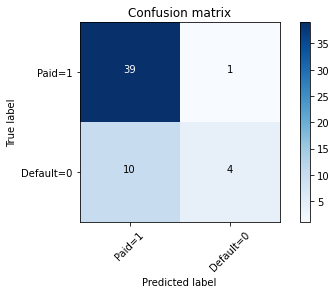

In [140]:
svm_yhat = lin_svm.predict(X)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y,svm_yhat, labels=[1,0])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Paid=1','Default=0'],normalize= False,  title='Confusion matrix')

# Report

You should be able to report the accuracy of the built model using different evaluation metrics:


| Algorithm          | Jaccard | F1-score | LogLoss |
| ------------------ | ------- | -------- | ------- |
| KNN                | ?       | ?        | NA      |
| Decision Tree      | ?       | ?        | NA      |
| SVM                | ?       | ?        | NA      |
| LogisticRegression | ?       | ?        | ?       |


<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

## Change Log

| Date (YYYY-MM-DD) | Version | Changed By    | Change Description                                                             |
| ----------------- | ------- | ------------- | ------------------------------------------------------------------------------ |
| 2020-10-27        | 2.1     | Lakshmi Holla | Made changes in import statement due to updates in version of  sklearn library |
| 2020-08-27        | 2.0     | Malika Singla | Added lab to GitLab                                                            |

<hr>

## <h3 align="center"> © IBM Corporation 2020. All rights reserved. <h3/>

<p>
